Load all the necessary packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

!pip install xgboost

from xgboost import XGBRegressor

## SKLEARN
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor, ElasticNet
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score, train_test_split, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


## Starting with the scaled totals.

I'll drop the Population, Total and Female_Population columns.


In [3]:
df = pd.read_csv("..\\data\\merged_data_sets\\merged_data_scaled_totals.csv")
df.info()
numerical_columns = [c for c in df.columns[3:] if c != "Births"]
y_full = df.Maternal_Mortality_Rate.values
X_full = df[numerical_columns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   State                                   170 non-null    object 
 1   Year                                    170 non-null    int64  
 2   Maternal_Mortality_Rate                 170 non-null    float64
 3   $10,000 to $14,999                      170 non-null    float64
 4   $100,000 to $149,999                    170 non-null    float64
 5   $15,000 to $24,999                      170 non-null    float64
 6   $150,000 to $199,999                    170 non-null    float64
 7   $200,000 or more                        170 non-null    float64
 8   $25,000 to $34,999                      170 non-null    float64
 9   $35,000 to $49,999                      170 non-null    float64
 10  $50,000 to $74,999                      170 non-null    float6

### Train Test Split

In [4]:
df_train, df_test, y_train, y_test = train_test_split(X_full, y_full, test_size= .2, shuffle=True, random_state=1029)
X_train = df_train.values
X_test = df_test.values
features = list(df_train.columns)
df_train['maternal_mortality_rate'] = y_train
target = 'maternal_mortality_rate'




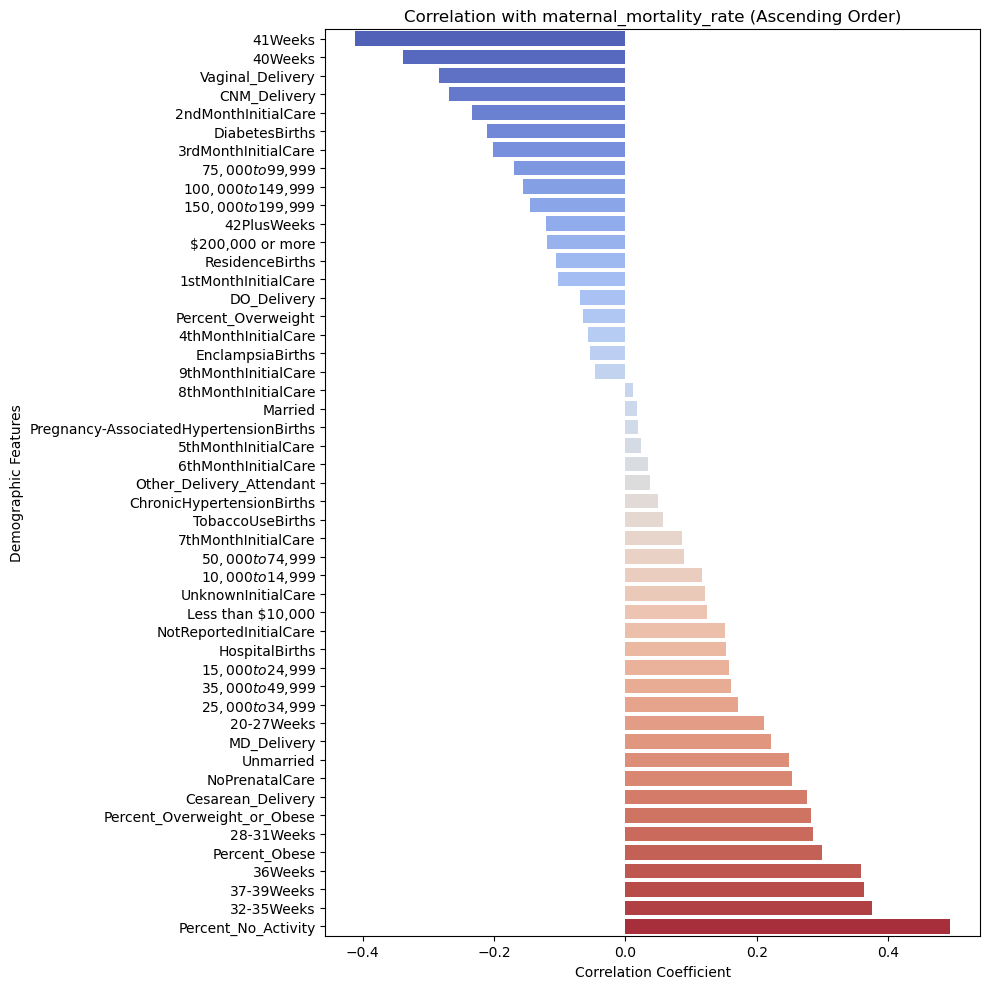

In [5]:
correlation_matrix = df_train[features + [target]].corr()
# Extract the correlations with the target variable
target_correlation = correlation_matrix[target].drop(target)
plt.figure(figsize=(10, 10))
sorted_correlations = target_correlation.sort_values() # Sort the target correlations in ascending order
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='coolwarm', hue=target_correlation.index,legend=False)

plt.title('Correlation with ' + target + ' (Ascending Order)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Demographic Features')

plt.tight_layout()
plt.show()

### Cross-validation

In [6]:
cv_classes = 5
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=110)

In [7]:
### Add models without parameters we'll tune:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state= 110),
    'SkLearn_GradientBoosting': GradientBoostingRegressor()
    }

### Models with tunable parameters:
model_and_params = {
    'Lasso': {'model': Lasso(max_iter = 10000),
                'params':  {'alpha': list(np.linspace(1/10, 2, 19))}},
    'Ridge': {'model': Ridge(max_iter = 10000),
                'params':  {'alpha': list(np.linspace(1/10, 2, 19))}},
    'ElasticNet': {"model" : ElasticNet(max_iter = 10000),
                'params': {'alpha':list(np.linspace(1/10, 2, 19)),
                                'l1_ratio': [j/10 for j in range(1,10)]}},
    'KNN': {"model": KNeighborsRegressor(),
                    'params': {'n_neighbors' : [j for j in range(2,10)]} }
}



In [8]:
data_frame_dict = {}

for name, model in model_and_params.items():
    A  = GridSearchCV(estimator = model['model'], param_grid=model['params'], cv = rkf, scoring = 'neg_mean_squared_error', return_train_score=True)
    A.fit(X_train,y_train)
    data_frame_dict[name] = pd.DataFrame(A.cv_results_)




In [9]:
for name, model in models.items():
    A = GridSearchCV(estimator = model, param_grid={}, cv = rkf, scoring = 'neg_mean_squared_error', return_train_score=True)
    A.fit(X_train,y_train)
    data_frame_dict[name] = pd.DataFrame(A.cv_results_)

In [13]:
data_frame_dict["RandomForest"].shape

(1, 110)

In [37]:
combine_data_frame_dict = {
    "method":[],
    "params":[],
    "mean_train_score":[],
    "std_train_score":[],
    "mean_test_score":[],
    "std_test_score":[]
}

for method, data_frame in data_frame_dict.items():
    for key in combine_data_frame_dict.keys():
        if key == "method":
            combine_data_frame_dict[key].extend([method for _ in range(data_frame.shape[0])])
        elif "mean" in key:
            combine_data_frame_dict[key].extend(list(-data_frame[key].values))
        else: 
            combine_data_frame_dict[key].extend(list(data_frame[key].values))

combined_df = pd.DataFrame(combine_data_frame_dict)


In [38]:
combined_df.sort_values("mean_test_score", ascending=True, inplace=True)
combined_df.reset_index(inplace=True)
combined_df.drop(columns="index", inplace=True)

In [39]:
combined_df.head(20)

,method,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,RandomForest,{},11.679597,1.070673,84.572163,27.418957
1,SkLearn_GradientBoosting,{},0.848758,0.162287,88.710502,24.534972
2,Ridge,{'alpha': 0.41666666666666663},95.019737,5.868192,111.207225,26.530403
3,Ridge,{'alpha': 0.3111111111111111},93.960246,5.751653,111.212496,26.224475
4,Ridge,{'alpha': 0.5222222222222223},95.801726,5.959106,111.213164,26.738062
5,Ridge,{'alpha': 0.6277777777777778},96.411482,6.032350,111.223293,26.886001
6,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.1}",102.463294,6.609750,111.229949,27.126778
7,Ridge,{'alpha': 0.7333333333333333},96.905041,6.092760,111.234491,26.994885
8,ElasticNet,"{'alpha': 0.20555555555555555, 'l1_ratio': 0.1}",103.358583,6.614517,111.239261,27.038106
9,ElasticNet,"{'alpha': 0.7333333333333333, 'l1_ratio': 0.1}",104.530228,6.625293,111.239319,27.049357
